### Train a PPO agent

In [ ]:
%run ppo_sagin_v1_0.py

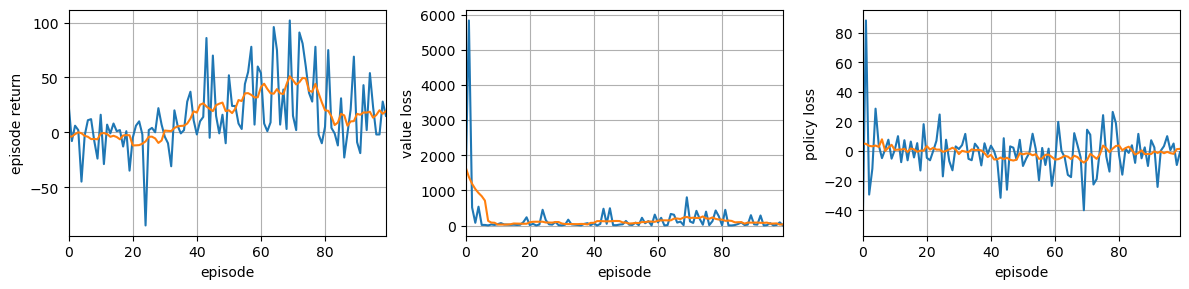

In [19]:
import pandas as pd

window = 10

df = pd.DataFrame({
        'episode return': log_ep_return,
        'value loss': log_value_loss,
        'policy loss': log_policy_loss
})

fig, axs = plt.subplots(nrows=1, ncols=len(df.columns), figsize=(12,3))
for i, col in enumerate(df.columns):
        axs[i].plot(df[col])
        axs[i].plot(df[col].rolling(window=window, min_periods=1, center=True).mean())
        axs[i].set_xlabel('episode')
        axs[i].set_ylabel(col)
        axs[i].margins(x=0)
        axs[i].grid(True)
        fig.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "tmp", f"training.png"))
plt.show()
plt.close()

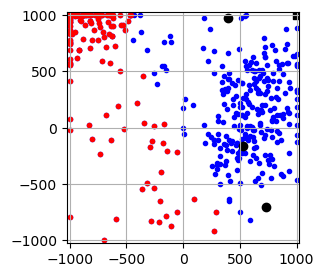

In [10]:
""" PLOTTING """
mbs_locs = env.unwrapped.locs['mbs']
user_locs = env.unwrapped.locs['user']
uav_locs = env.unwrapped.locs['uav']
mask = env.unwrapped.infos['global']['drates'] <= env.unwrapped.drate_threshold
user_locs_2 = env.unwrapped.locs['user'][:, mask]

fig = plt.figure(figsize=(3,3))
axs = fig.gca()
axs.set_xlim(-1000-25, 1000+25)
axs.set_ylim(-1000-25, 1000+25)
axs.grid(True)
axs.scatter(user_locs[0], user_locs[1], marker=".", color='b')
axs.scatter(user_locs_2[0], user_locs_2[1], marker=".", color='r')
axs.scatter(uav_locs[0], uav_locs[1], marker='o', color='k')
axs.scatter(mbs_locs[0], mbs_locs[1], marker='s', color='k')
fig.savefig("tmp/trajectory.png")
plt.show()

### Test the trained agent

##### Movements of UAVs

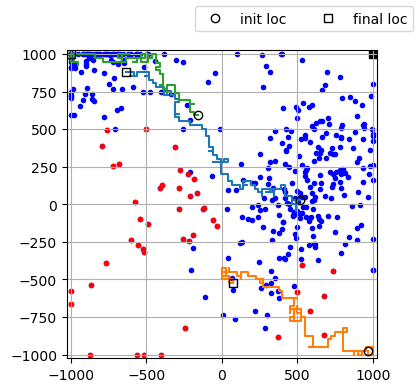

In [15]:
""" RENDER THE POLICY """
env = parallel_env(seed=42, max_cycles=200)
# env = color_reduction_v0(env)
# env = resize_v1(env, 64, 64)
# env = frame_stack_v1(env, stack_size=4)

agent.eval()

n_episodes = 1
log_uav_locs = []

with torch.no_grad():
    # render some episodes out
    for episode in range(n_episodes):
        obs, infos = env.reset(seed=None)
        obs = batchify_obs(obs, device)
        terms = [False]
        truncs = [False]
        while not any(terms) and not any(truncs):
            # loggging
            log_uav_locs.append(env.unwrapped.locs['uav'].copy())

            actions, logprobs, _, values = agent.get_action_and_value(obs)
            obs, rewards, terms, truncs, infos = env.step(unbatchify(actions, env))
            obs = batchify_obs(obs, device)
            terms = [terms[a] for a in terms]
            truncs = [truncs[a] for a in truncs]
        env.close()

""" PLOTTING """
mbs_locs = env.unwrapped.locs['mbs']
log_uav_locs = np.array(log_uav_locs)
n_uavs = log_uav_locs.shape[-1]
user_locs = env.unwrapped.locs['user']
mask = env.unwrapped.infos['global']['drates'] <= env.unwrapped.drate_threshold
user_locs_2 = env.unwrapped.locs['user'][:, mask]

fig = plt.figure(figsize=(4,4))
axs = fig.gca()
axs.set_xlim(-1000-25, 1000+25)
axs.set_ylim(-1000-25, 1000+25)
axs.grid(True)
for uav_id in range(n_uavs):
    loc_uav = log_uav_locs[:, :, uav_id].transpose()
    axs.plot(loc_uav[0], loc_uav[1])
    if uav_id == n_uavs - 1:
        l_init, l_final = "init loc", "final loc"
    else:
        l_init, l_final = "", ""
    axs.plot(loc_uav[0][0], loc_uav[1][0], 'ok', markerfacecolor="None", label=l_init)
    axs.plot(loc_uav[0][-1], loc_uav[1][-1], 'sk', markerfacecolor="None", label=l_final)
axs.scatter(user_locs[0], user_locs[1], marker=".", color='b')
axs.scatter(user_locs_2[0], user_locs_2[1], marker=".", color='r')
axs.scatter(mbs_locs[0], mbs_locs[1], marker='s', color='k')
fig.legend(ncol=2)
fig.savefig("tmp/trajectory.png")
plt.show()

##### Observations of agents

Image saved to /mnt/newdiskpartition/uavbs-placement-marl/code/tmp/uav_0.png
Image saved to /mnt/newdiskpartition/uavbs-placement-marl/code/tmp/uav_1.png
Image saved to /mnt/newdiskpartition/uavbs-placement-marl/code/tmp/uav_2.png


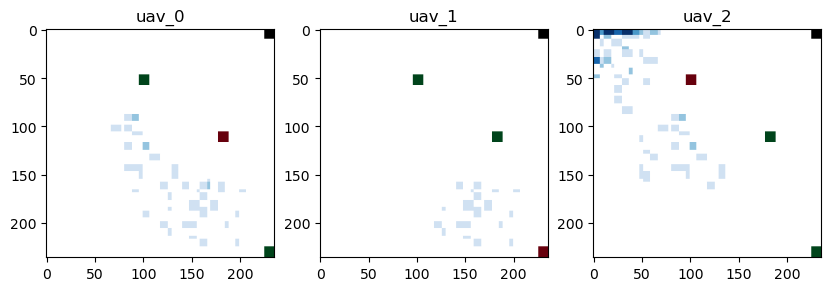

In [14]:
env = parallel_env(seed=42, max_cycles=200)
env.reset()
hms = {}
for uav in env.agents:
    hms[uav] = env.unwrapped.observe(uav)

for uav, hm in hms.items():
    save_img_from_rgba_arr(hm,  figsize=(4,4), dpi=64, transparent=False, fpath=f"tmp/{uav}.png")

env.close()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
for i, uav in enumerate(hms.keys()):
    im = plt.imread(f"tmp/{uav}.png")
    axs[i].imshow(im)
    axs[i].set_title(f"{uav}")
plt.show()

In [13]:
'''Check the total params of the NN'''
# agent = Agent(num_actions=num_actions).to(device)
model = agent.network

# Ref: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
pytorch_total_params = sum(p.numel() for p in model.parameters())
print('total params: %s M'%(pytorch_total_params/1e6))

total params: 2.098256 M
